# Решение домашнего задания #4

Для решения будем использовать GPT модель от Андрея Карпатого (https://github.com/karpathy/nanoGPT/blob/master/model.py), однако для большей эффективности вычислений будем использовать уже готовый модули PyTorch.

### Базовая настройка

In [1]:
from GPT import GPT, GPTConfig

import torch
from torch.utils.data import DataLoader

from lightning.pytorch import Trainer, LightningModule

from transformers import GPT2Tokenizer

import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
torch.set_float32_matmul_precision('medium')

In [3]:
TARGET_ROW = "To prove that"

In [4]:
config = GPTConfig()

### Загрузка датасета (датасет латеховских статей) и токенайзера (токенайзер GPT-2)

In [5]:
# !curl -f https://huggingface.co/datasets/hoskinson-center/proof-pile/resolve/refs%2Fconvert%2Fparquet/default/partial-train/0000.parquet -o ../../data/proof-pile/0000.parquet
# !curl -f https://huggingface.co/datasets/hoskinson-center/proof-pile/resolve/refs%2Fconvert%2Fparquet/default/partial-train/0001.parquet -o ../../data/proof-pile/0001.parquet
# !curl -f https://huggingface.co/datasets/hoskinson-center/proof-pile/resolve/refs%2Fconvert%2Fparquet/default/partial-train/0002.parquet -o ../../data/proof-pile/0002.parquet

In [6]:
train_ds = pd.concat([pd.read_parquet(f'../../data/proof-pile/000{i}.parquet') for i in range(3)], ignore_index=True)
text_data = train_ds['text'].tolist()

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

### Теперь нам нужен кастомный лоадер для тренировки

In [8]:
class CustomLoader(DataLoader):
    def __init__(self, texts, tokenizer, loader_size=16, batch_size=16, block_size=config.block_size):
        self.texts = texts
        self.tokenizer = tokenizer
        self.batch_size = batch_size
        self.block_size = block_size
        self.loader_size = loader_size

        self.text_id = -self.loader_size
        self.page_tokens = None
        self.page_training_pairs = None

        self.next_page()

        super().__init__(self, batch_size=batch_size)

    def next_page(self):
        self.text_id += self.loader_size
        if self.text_id + self.loader_size > len(self.texts):
            self.text_id = 0
        self.page_tokens = [
            self.tokenizer.encode(self.texts[self.text_id + i])
            for i in range(self.loader_size)
        ]
        self.page_training_pairs = torch.tensor([
            [
                tokens[i:i + self.block_size],
                tokens[i + 1:i + self.block_size + 1]
            ]
            for tokens in self.page_tokens
            for i in range(0, len(tokens) - self.block_size)
        ])
        self.page_training_pairs = self.page_training_pairs[torch.randperm(len(self.page_training_pairs))]

    def __iter__(self):
        for i in range(0, len(self.page_training_pairs), self.batch_size * 30):
            yield self.page_training_pairs[i:i + self.batch_size, 0, :], self.page_training_pairs[i:i + self.batch_size, 1, :]

    def __len__(self):
        return len(self.page_training_pairs) // self.batch_size // 30

### Теперь мы готовы к обучению

In [9]:
dl = CustomLoader(text_data, tokenizer)

Token indices sequence length is longer than the specified maximum sequence length for this model (7399 > 1024). Running this sequence through the model will result in indexing errors


In [10]:
class LightningGPT(LightningModule):
    def __init__(self, config, tokenizer):
        super().__init__()
        self.model = GPT(config)
        self.tokenizer = tokenizer

        self.loss_history = []

    def forward(self, idx, targets=None):
        logits, loss = self.model(idx, targets)
        return logits, loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.model.parameters(), lr=3e-4, eps=1e-8, betas=(0.9, 0.95), fused=True)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer, T_0=10, T_mult=2, eta_min=1e-5
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'interval': 'epoch',
                'frequency': 1,
            }
        }
    
    def training_step(self, batch, batch_idx):
        idx, targets = batch
        _, loss = self.model.forward(idx, targets)
        self.log('train/loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=False)
        self.loss_history.append(loss.item())
        return loss
    
    def on_train_epoch_start(self):
        query_tokens = self.tokenizer.encode(TARGET_ROW, return_tensors='pt').to(self.device)
        generated_tokens = self.model.generate(
            idx=query_tokens,
            max_new_tokens=10,
            top_k=10
        )
        generated_text = self.tokenizer.decode(generated_tokens[0], skip_special_tokens=True)
        print('test/generated_text', generated_text)
        
        return super().on_train_epoch_start()
    
    def on_train_epoch_end(self):
        dl.next_page()

        return super().on_train_epoch_end()

In [11]:
model = LightningGPT(config, tokenizer)

In [ ]:
trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    enable_progress_bar=True,
    logger=False,
    enable_checkpointing=False,
)
trainer.fit(model, train_dataloaders=dl)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params | Mode 
---------------------------------------
0 | model | GPT  | 15.0 M | train
---------------------------------------
15.0 M    Trainable params
0         Non-trainable params
15.0 M    Total params
59.985    Total estimated model params size (MB)
128       Modules in train mode
0         Modules in eval mode
c:\Users\setday\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

test/generated_text To prove that that upgraded Lo bureaucracy Princess Tearsmut Conradename fixation
test/generated_text To prove that$ \ ${ \\ \ \ \}
test/generated_text To prove that \ul}$. 
    \
test/generated_text To prove that  
  \in C_{k}
test/generated_text To prove that the exact followingorem \ref{eq{the
test/generated_text To prove that the series and 
\label{s3
test/generated_text To prove that $\mathbbP(\tau_{\{
test/generated_text To prove that 
     $t\in
test/generated_text To prove that the $X_p \q 2 \sub


In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(x=range(len(model.loss_history)), y=model.loss_history, label='Loss')

### Смотрим, что же получилось

_предварительно откатываем модель до 3-ей эпохи_

In [ ]:
tokens = model.model.generate(
    idx=torch.tensor(tokenizer.encode(TARGET_ROW)).unsqueeze(0).to(model.device),
    max_new_tokens=30,
    top_k=10
)
generated_text = tokenizer.decode(tokens[0], skip_special_tokens=True)
print('test/generated_text', generated_text)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
def plot_weights(weights, title='Attention Weights'):
    fig, ax = plt.subplots(3, 4, figsize=(12, 6))
    fig.suptitle(title, fontsize=16)

    for i in range(weights.shape[0]):
        sns.heatmap(weights[i].detach().cpu().numpy(), ax=ax[i // 4][i % 4], square=True)
        ax[i // 4][i % 4].set_title(f'Head {i+1}')
        ax[i // 4][i % 4].axis('off')

    plt.tight_layout()
    plt.show()

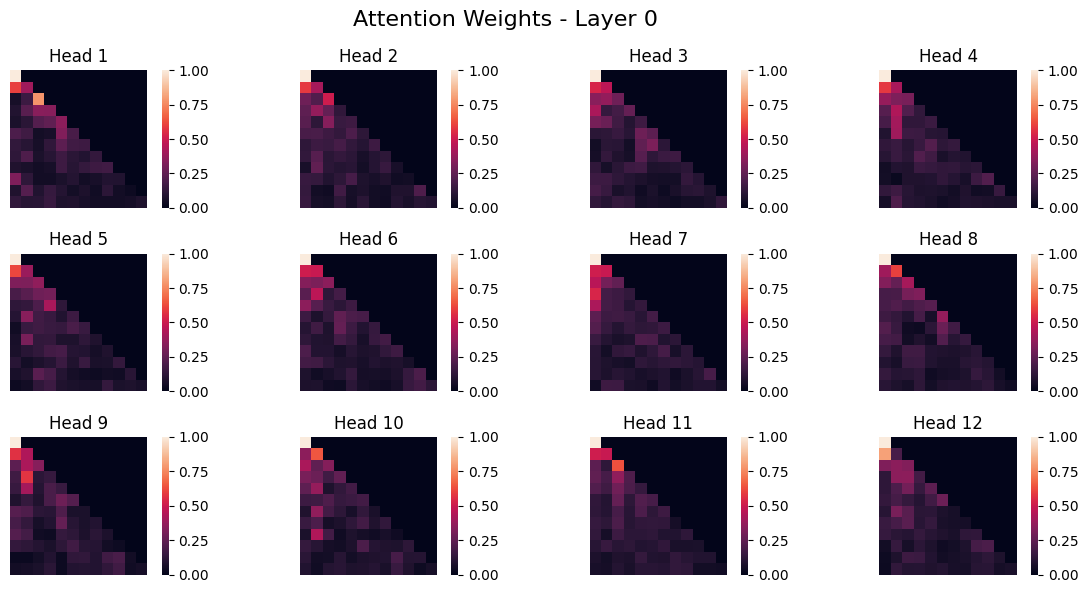

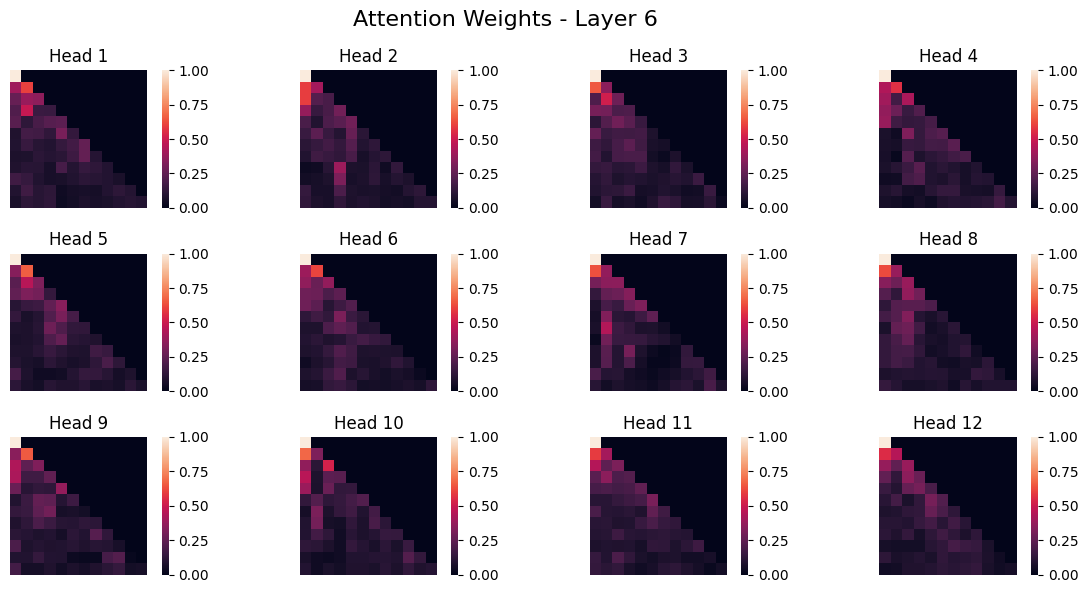

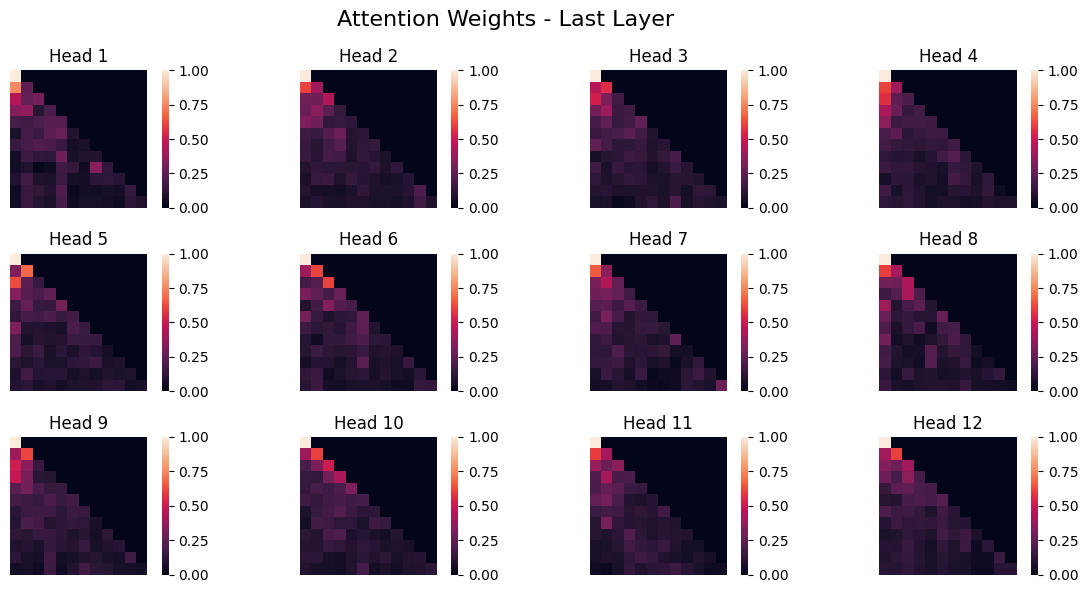

In [ ]:
plot_weights(model.model.transformer.h[0].saved_head_weight[0], title='Attention Weights - Layer 0')
plot_weights(model.model.transformer.h[6].saved_head_weight[0], title='Attention Weights - Layer 6')
plot_weights(model.model.transformer.h[-1].saved_head_weight[0], title='Attention Weights - Last Layer')

# Итоги

1. Модель довольно быстро обучилась на корпусе научных статей (`за 3 эпохи`). Это связано с тем, что в ней весьма мало параметров (`15 M`), равно как и мало контекстное окно (`128 токенов`). Дальше наинает происходить уже переобучение, которое легко заметить по повторяющимся токенам.
2. На графики потерь заметны пики при переходе к новым эпохам. В основном это связано с тем, что в новых документах появляются новые конструкции (в одной эпохе используется `16 документов`). Это может также свидетельствовать о переобучении на конкретных документах. Дабы нивелировать этот эффект, количество элементов эпохи было сокращено в `30 раз`, а сами данные перемешаны.
3. Интересная ситуация происходит и с головами: головы первого уровня распыляют своё внимание на весь контекст, тогда как ближе к концу у нас уже соединяются отдельные конструкции (отдельные токены). При переобучении (на `10 эпохе`) все головы выглядят почти одинаково - внимание только на первых токенах, что очень легко объясняет то, почему модель начинает повторяться.